In [138]:
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

### 1.  Data is readed and explored
We begin by reading the whole dataset into a Pandas Dataframe.  
To check for proper import the head is shown.

In [139]:
random_state = 42  # set in order to guarantee repetability of results
data_url1 = 'seeds_dataset.txt'
sep1 = '\n'
df = np.loadtxt(data_url1)
X = pd.DataFrame(df)

In [140]:
X.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0.0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0.0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0.0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0.0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0.0


The dataset is then split in X and y, attributes and class label respectively.

In [141]:
y = X[7]
X = X.drop(7, axis=1)

A pairplot of the attributes is produced using the seaborn method.

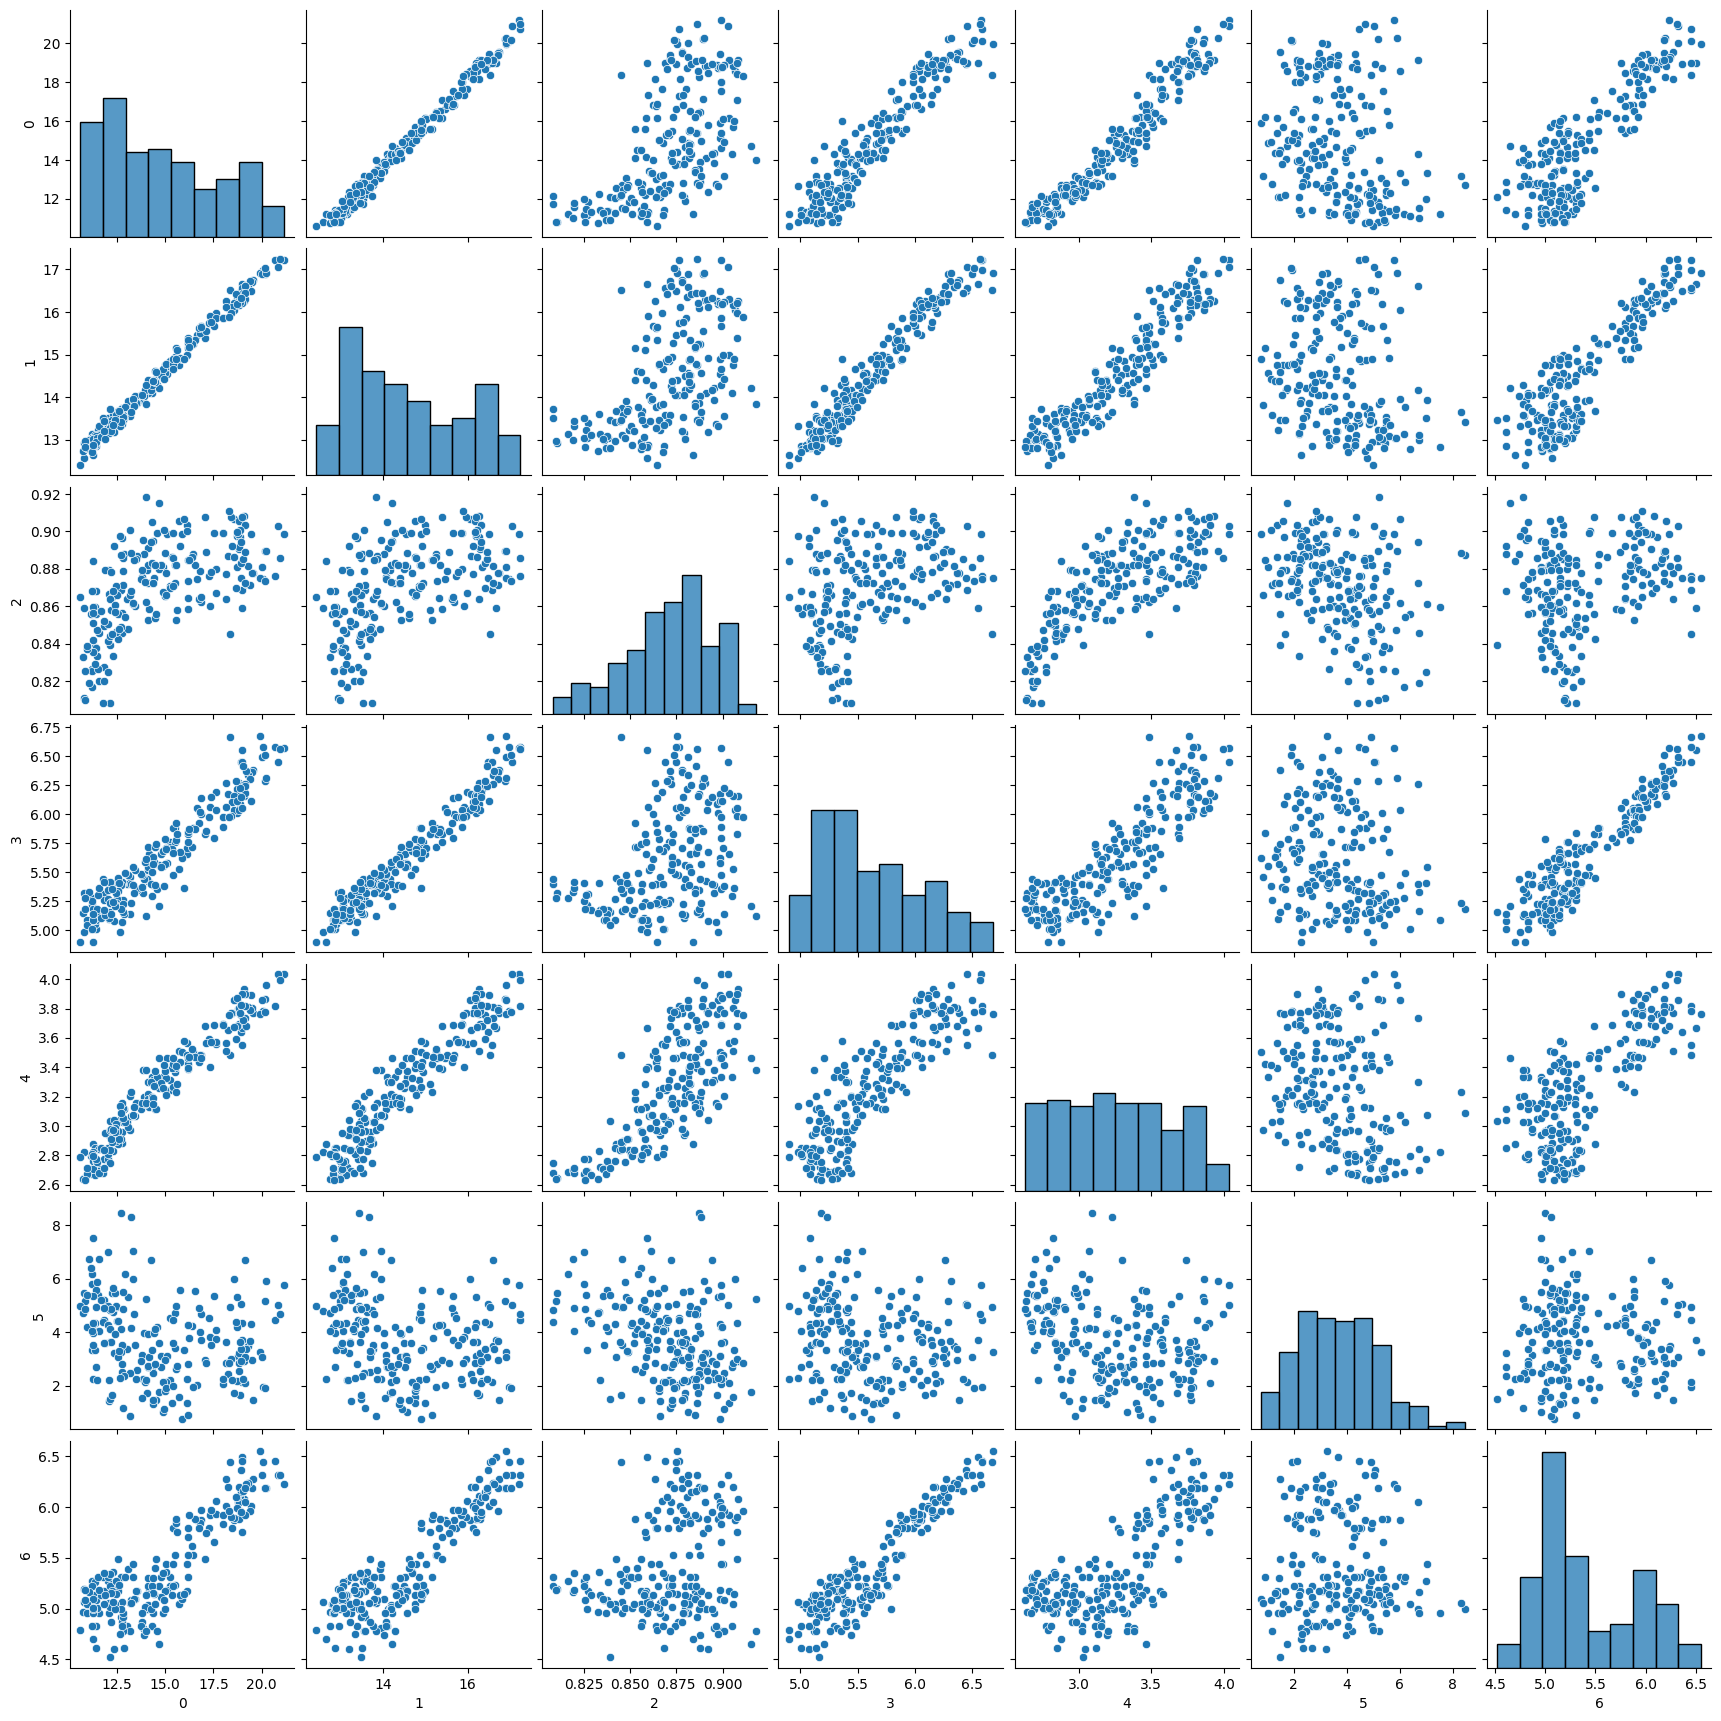

In [142]:
sns.pairplot(X)

In the attribute pairs with attribute 6 the data looks more separable,
4-6 pair is choosen because the supposed clusters look isotropic.  
This will be valuable for some clustering schemes.

In [143]:
# set the range of k values to test
k_range = list(range(2, 11))  
#Create all possible combinations with parameters
parameters_km = [{'n_clusters': k_range}]
pg = list(ParameterGrid(parameters_km))

inertias_km = []
silhouette_scores_km = []
for i in range(len(pg)):
    km = KMeans(**(pg[i]), random_state=random_state)
    y_km = km.fit_predict(X)
    inertias_km.append(km.inertia_)
    silhouette_scores_km.append(silhouette_score(X, y_km))


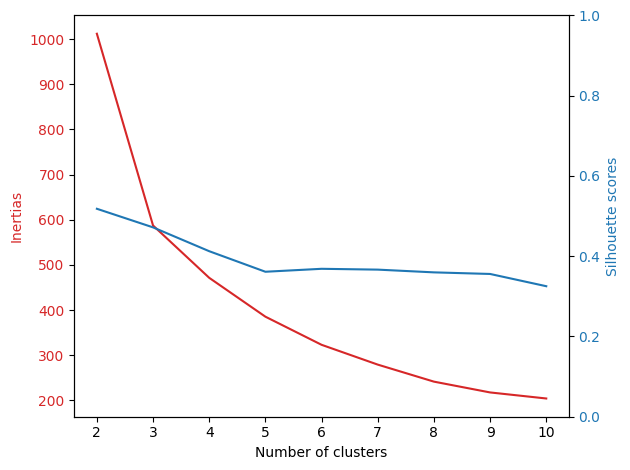

In [144]:
# Plot inertia e siluettescore
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    # we already handled the x-label with ax1
    ax2.set_ylabel(y2label, color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1)  # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


two_plots(x=k_range, y1=inertias_km, y2=silhouette_scores_km, xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
          )

It looks like the best values for the parameter n_clusters to consider can be both 2 or 3 since they are quite comparable in term of silhouette scores and inertias, with the value in 2 a bit accentuated for inertia while the value 3 has a worse silhouette score.

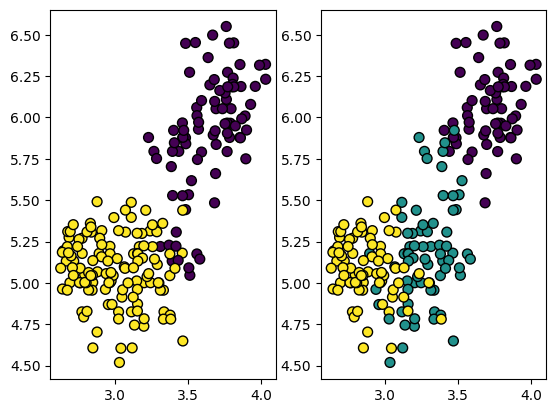

In [145]:
#Let's see how they perform visually on the considered features
k_range = [2,3]  # set the range of k values to test
parameters_km = [{'n_clusters': k_range}]
pg = list(ParameterGrid(parameters_km))
ys_predictions_km = []
silhouette_scores_km = []
inertias_km =[]


for i in range(len(pg)):
    km = KMeans(**(pg[i]), random_state=random_state)
    y_km = km.fit_predict(X)
    inertias_km.append(km.inertia_)
    silhouette_scores_km.append(silhouette_score(X, y_km))
    ys_predictions_km.append(y_km)
    plt.subplot(1,2,i+1)
    #Scatterplot of interesting columns of the pairplot
    interesting_columns = [4,6]
    plt.scatter(X.iloc[:,interesting_columns[0]], X.iloc[:,interesting_columns[1]]
                , c=y_km         # color filling the data markers
                , edgecolors='black' # edge color for data markers
                , marker='o'         # data marker shape, e.g. triangles (v<>^), square (s), star (*), ...
                , s=50)              # data marker size
 
     
    
plt.show()



We choose 3

In [146]:
from sklearn.metrics import confusion_matrix
from max_diag import max_diag

y_pred = ys_predictions_km[1]
conf = confusion_matrix(y, y_pred)
cm_km =  max_diag(confusion_matrix(y,y_km))
print('Confusion matrix for k =',3)
print(cm_km)

Confusion matrix for k = 3
[[60.  1.  9.]
 [10. 60.  0.]
 [ 2.  0. 68.]]


### 5. The accuracy of the best scheme is computed
The schema accuracy is computed as follows:  

compute the accuracy a_km of y_km versus y  
as the ratio the sum of the main diagonal of cm_km and the number of samples in X

In [147]:
cm_km_numpy = np.array(cm_km)    
a_km = sum(cm_km_numpy.diagonal()/X.shape[0])
print("accuracy is {:.2f} %".format(a_km*100))

accuracy is 89.52 %


### 6. Data is rescaled for further analisys
Unsipervised data in X is rescaled using sklearn.preprocessing.MinMaxScaler, producing the scaled dataset X_mms

In [148]:
#MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_mms = pd.DataFrame(mms.fit_transform(X))
X_mms.head()

,0,1,2,3,4,5,6
0,0.440982,0.502066,0.570780,0.486486,0.486101,0.189302,0.345150
1,0.405099,0.446281,0.662432,0.368806,0.501069,0.032883,0.215165
2,0.349386,0.347107,0.879310,0.220721,0.503920,0.251453,0.150665
3,0.306893,0.316116,0.793103,0.239302,0.533856,0.194243,0.140817
4,0.524079,0.533058,0.864791,0.427365,0.664291,0.076701,0.322994


### 7.The clustering task is repeated

- fit on the scaled data X_mms
- production of confusion matrix and reorder
- accuracy computing



In [156]:
# Let's see how they perform visually on the considered features
km_mms = KMeans(n_clusters=3, random_state=random_state)
y_km_mms = km_mms.fit_predict(X_mms)



conf_mms = confusion_matrix(y, y_km_mms)
cm_km_mms =  max_diag(confusion_matrix(y,y_km_mms))
print('Confusion matrix for k =',3)
print(cm_km_mms)

cm_km_mms = np.array(cm_km_mms)    
a_km_mms = sum(cm_km_mms.diagonal()/X.shape[0])
print("accuracy is {:.2f} %".format(a_km_mms*100))


Confusion matrix for k = 3
[[58.  2. 10.]
 [ 8. 62.  0.]
 [ 3.  0. 67.]]
accuracy is 89.05 %
